## Stroke Data

Source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In this notebook I will be using 10 features to predict binary stroke outcomes (1 = stroke, 0 = no stroke). The dataset includes 11 features, but one is a unique identifier (column = 'id') that will be dropped for it adds no benefit to the analysis.

The dataset has 5110 samples, so the following models may be appropriate for the binary classification task:
- Logistic Regression: 
- Linear Support Vector Machine
- KNeighbors Classifier

Let's get the data and see what we're working with.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [20]:
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


A quick glance suggests that bmi is the only feature missing values.

In [4]:
df.shape

(5110, 12)

In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


I find the minimum age (0.08) surprising for a stroke study. Let's make sure that nothing else seems unusual about that feature vector.

In [57]:
df[df.age == df.age.min()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0


Turns out there are 2 instances where the age is 0.08! Neither had a stroke. Let's explore infant patient data a little more:

In [12]:
df.sort_values(by='age').head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3618,22877,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
4021,8247,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0
3968,41500,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0
3392,11371,Male,0.24,0,0,No,children,Urban,89.28,14.2,Unknown,0
996,53279,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
2898,64974,Male,0.24,0,0,No,children,Urban,58.35,18.6,Unknown,0
4293,69222,Male,0.24,0,0,No,children,Urban,57.09,19.4,Unknown,0
1999,42500,Male,0.24,0,0,No,children,Rural,146.97,18.5,Unknown,0


In [18]:
len(df[df.age<1])

43

### Exploratory Data Analysis

For the 10 instances shown above, all were missing smoking_status information. Let's explore the smoking_status feature a little more for young persons:

In [29]:
df[df.age<1]['smoking_status'].value_counts()

Unknown    43
Name: smoking_status, dtype: int64

In [32]:
df[df.age<10]['smoking_status'].value_counts()

Unknown    472
Name: smoking_status, dtype: int64

In [49]:
df[df.age<15]['smoking_status'].value_counts()

Unknown            614
never smoked        65
formerly smoked     17
smokes               3
Name: smoking_status, dtype: int64

In [76]:
len(df[(df['smoking_status'].isin(['formerly smoked','smokes'])) & (df.age<15)]) / len(df[df.age<15])

0.02861230329041488

Only 2.861% of study participants under the age of 15 are recorded as "smokes" or "formerly smoked". We will therefore classify the 614 "Unknown[s]" as "never smoked" when we prep the data.

In [77]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [102]:
len(df[(df['smoking_status'].isin(['Unknown'])) & (df.age<15)]) / len(df[df.smoking_status=='Unknown'])

0.39766839378238344

The new assignment for "Unknown[s]" under the age of 15 will take care of 40% of the total "Unknowns[s]" of the smoking_status feature

#### Balance
One of the first things to look for when performing binary classification is target-class balance. We want to see a somewhat even distribution across classes. 


<AxesSubplot:xlabel='stroke', ylabel='count'>

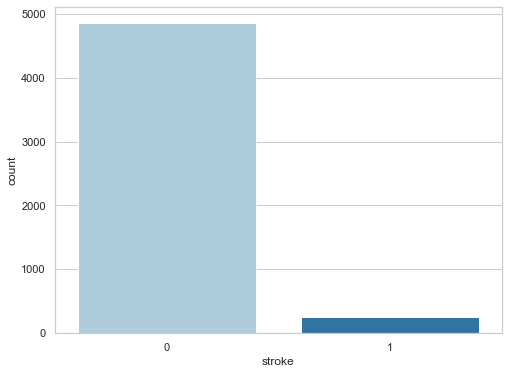

In [103]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,6))
sns.countplot(data=df, x='stroke', palette='Paired')

In [39]:
len(df[df['stroke']==1])

249

In [40]:
(len(df[(df.stroke==1)]) / len(df)) * 100

4.87279843444227

## Yikes!
The minority class, stroke = 1, represents only 4.873% of outcomes (249 occurences). Without further intervention, the imbalance of the target variable will likely result in poor classification results. 

To address the imbalance, we can either undersample the majority class or oversample the minority class. Given how small the dataset is (5110 instances), we will oversample the minority class using the Synthetic Minority Oversampling Technique (SMOTE). 

More on that later.

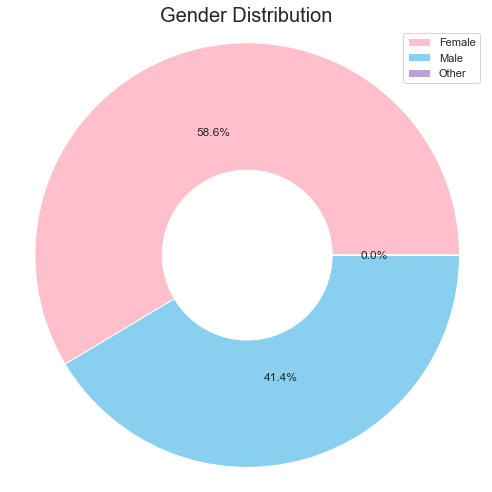

In [104]:
labels = ['Female', 'Male', 'Other']
colors = ['#ffc0cb', '#89cff0', '#bca0dc']


fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(x=df.gender.value_counts(), labels=labels, labeldistance=None, autopct='%1.1f%%', colors=colors)


centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.legend()
ax1.axis('equal')
plt.title('Gender Distribution', fontsize='20')
plt.tight_layout()
plt.show()

In [35]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

We'll eliminate the feature vector that includes the lone 'Other' gender instance--otherwise, encoding would results in 2 features rather than 1--and because removing it should have little effect.

##### Let's now check the gender distribution for instances where stroke=1.

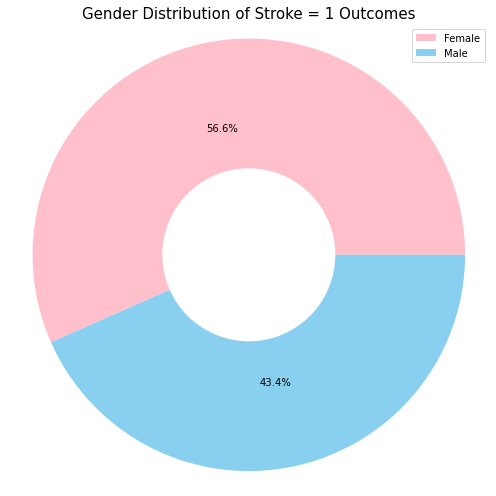

In [4]:
labels = ['Female', 'Male']
colors = ['#ffc0cb', '#89cff0']


fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(x=df[df.stroke==1].gender.value_counts(), labels=labels, labeldistance=None, autopct='%1.1f%%', colors=colors)


centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.legend()
ax1.axis('equal')
plt.title('Gender Distribution of Stroke = 1 Outcomes', fontsize='15')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='gender', ylabel='count'>

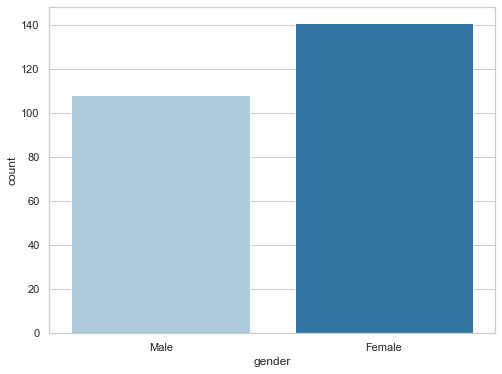

In [107]:
plt.figure(figsize=(8,6))
sns.countplot(x='gender', data=df[df.stroke == 1], palette='Paired')

#### Let's now evaluate stroke prevalence as a function of age using KDEs.

<AxesSubplot:xlabel='age', ylabel='Count'>

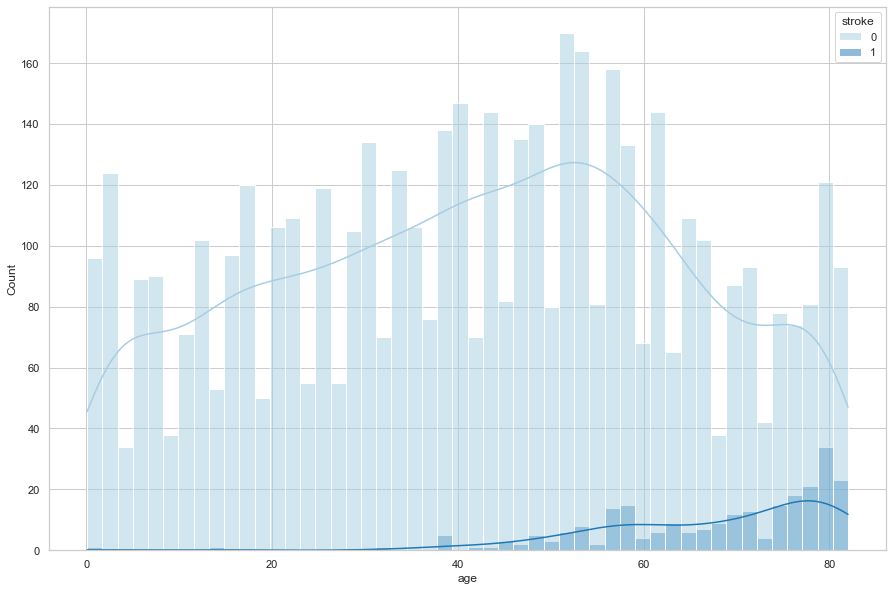

In [108]:
plt.figure(figsize=(15,10))
sns.histplot(data=df, x='age', hue='stroke', bins=50, kde=True, palette='Paired')

As expected, the prevalence of stroke = 1 outcomes increases with age. Stroke prevalence also seems correlated to population density. For example, the uptick in stroke = 1 outcomes just prior to age 40 may have some relationship with the high population density within that age group. 

We may want to consider re-plotting this with a uniform distribution of age. 

Or--just plotting this data again after performing the SMOTE analysis, as that should have a similar effect.

In [111]:
# Total stroke instances in patients less than 50 years old
len(df[(df['stroke'] == 1) & (df['age']<50)])

20

In [112]:
# Total stroke instances in patients aged 50 and over
len(df[(df['stroke'] == 1) & (df['age']>=50)])

229

<AxesSubplot:xlabel='age'>

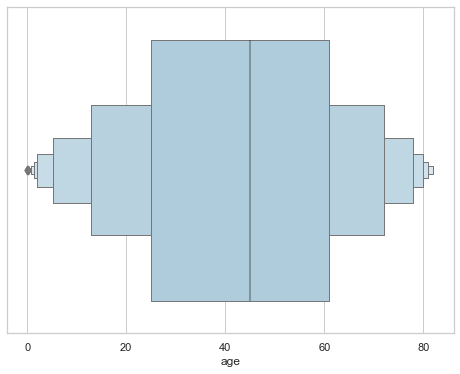

In [116]:
plt.figure(figsize=(8,6))
sns.boxenplot(x='age',data=df, palette='Paired')

<AxesSubplot:xlabel='work_type', ylabel='count'>

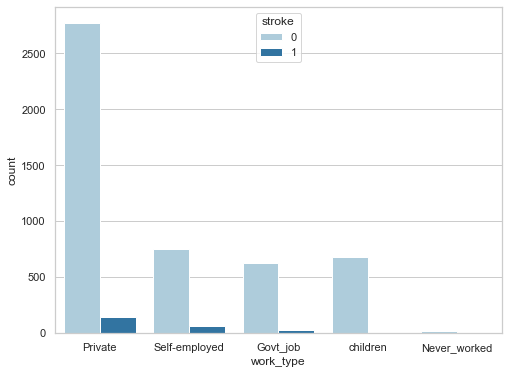

In [119]:
plt.figure(figsize=(8,6))
sns.countplot(x='work_type', data=df, hue='stroke', palette='Paired')

<AxesSubplot:>

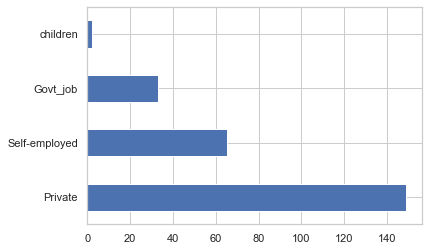

In [128]:
df[df['stroke']==1]['work_type'].value_counts().plot(kind='barh')

In [134]:
len(df[(df.work_type=='children') & (df.stroke==1)])

2

### Interesting!

There are no stroke victims in the "Never_worked" category, and only 2 in the "children" category. Our SMOTE analysis may increase the number of target=1 outcomes in "children", but it won't populate the "Never_worked" category. Let's take a closer look at "Never_worked." I'm guessing that the majority of individuals under this classification are young. If so, we may have to worry about multicollinearity between 'age' and 'work_type'.

In [4]:
df[df.work_type == 'Never_worked'].describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,22.000000,22.000000,22.0,22.0,22.000000,22.000000,22.0
mean,38274.409091,16.181818,0.0,0.0,96.042727,25.545455,0.0
std,20166.419938,2.342899,0.0,0.0,28.697132,7.441757,0.0
min,11702.000000,13.000000,0.0,0.0,59.990000,14.600000,0.0
25%,19830.750000,14.250000,0.0,0.0,78.457500,20.975000,0.0
50%,36054.500000,16.000000,0.0,0.0,86.020000,23.150000,0.0
75%,57202.000000,17.000000,0.0,0.0,112.807500,28.350000,0.0
max,71966.000000,23.000000,0.0,0.0,161.280000,44.900000,0.0


Sure enough, the youngest is 13 and the oldest is 23. We'll keep this in mind as we move forward.

<AxesSubplot:xlabel='Residence_type', ylabel='count'>

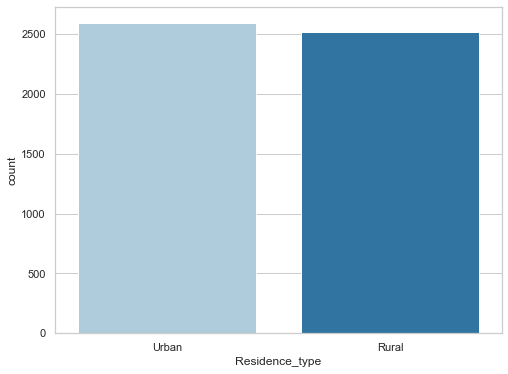

In [135]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Residence_type', palette='Paired')

<AxesSubplot:xlabel='ever_married', ylabel='count'>

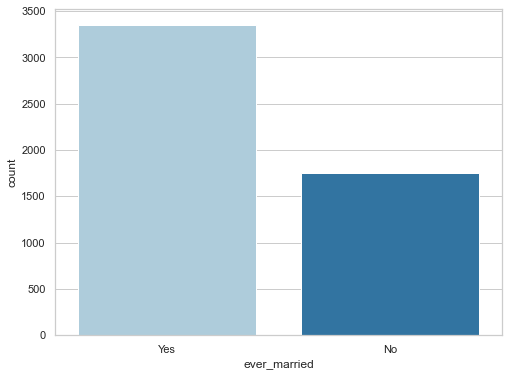

In [136]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='ever_married',palette='Paired')

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

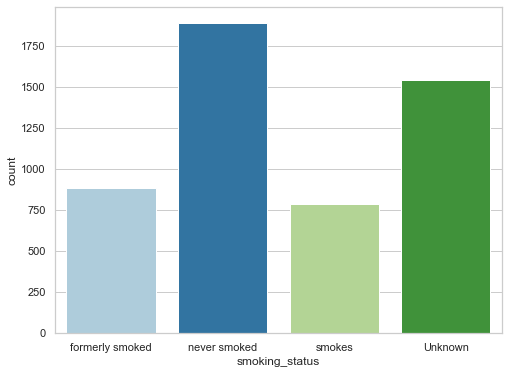

In [137]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='smoking_status', palette='Paired')

In [138]:
len(df[df['smoking_status'] == 'Unknown'])/len(df)*100

30.21526418786693

30% of the smoking_status feature is missing. We are going to need to take a few different approaches and compare their results. 

* Use a KNN imputer to classify the "Unknown" values
* Drop rows that have an "Unknown" smoking_status
* Drop the smoking_status feature


<AxesSubplot:xlabel='bmi', ylabel='Count'>

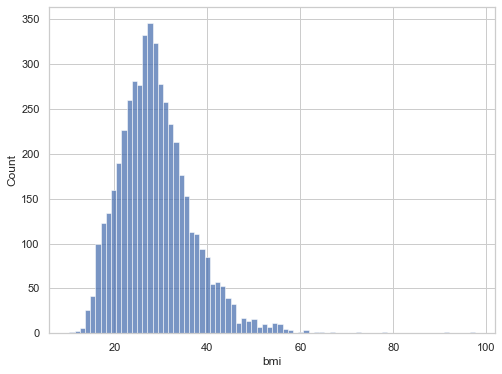

In [141]:
plt.figure(figsize=(8,6))
sns.histplot(x='bmi', data=df, palette='Paired')

In [142]:
df.bmi.isna().sum()

201

In [143]:
df.bmi.isna().sum()/len(df) * 100

3.9334637964774952

Only 3.93% of bmi values are missing, so we'll impute the mean for this feature.

In [144]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

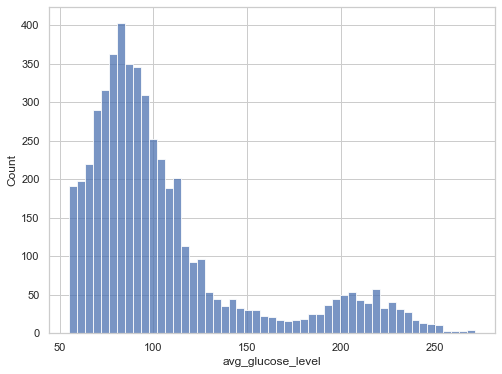

In [145]:
plt.figure(figsize=(8,6))
sns.histplot(x='avg_glucose_level', data=df, palette='Paired')

<AxesSubplot:xlabel='avg_glucose_level'>

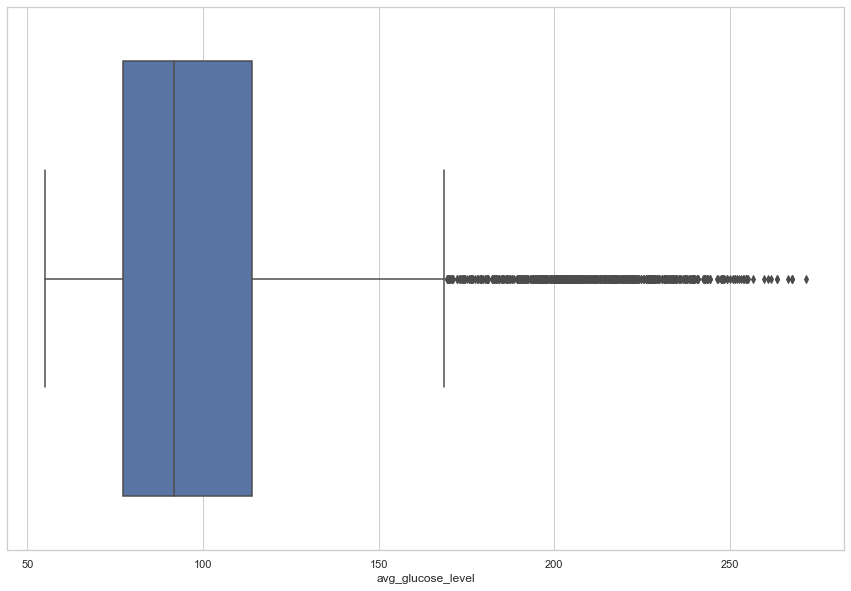

In [146]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df, x='avg_glucose_level')

avg_glucose_level appears to have a lot of outliers. Let's figure out just how many outliers it has.


In [147]:
len(df[df['avg_glucose_level'] > df['avg_glucose_level'].quantile(0.99)])

52

In [7]:
outliers = df[(np.abs(df.avg_glucose_level - df.avg_glucose_level.mean()) > (3*df.avg_glucose_level.std()))]

In [8]:
len(outliers)

49

There are 52 individuals above the 99th percentile and 49 individuals that are more than 3 standard deviations above the mean.

We know that stroke=1 is true for only ~5% of the dataset so before we consider removing the anomalous individuals, let's take note of the effect of an exceptionally high avg_glucose_level on the target variable. 

Text(0.5, 1.0, 'Stroke Outcomes w/ Respect to Anomolous Glucose Levels')

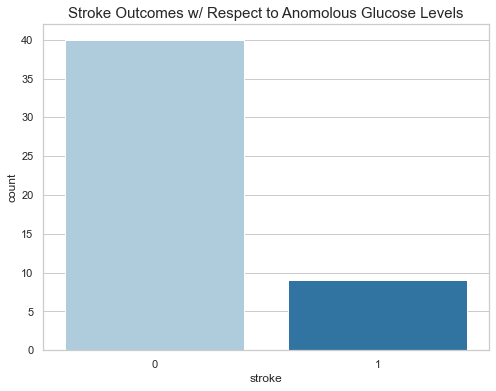

In [150]:
plt.figure(figsize=(8,6))
sns.countplot(data=outliers, x='stroke', palette='Paired')

plt.title('Stroke Outcomes w/ Respect to Anomolous Glucose Levels', fontsize='15')

In [151]:
# Percentage of glucose outlier cases where stroke = 1
len(outliers[outliers['stroke']==1]) / len(outliers[outliers['stroke']==0]) * 100

22.5

In [152]:
# Percentage of stroke = 1 instances where avg_glucose is an outlier
(len(outliers[outliers['stroke']==1])/len(df[df['stroke']==1])) * 100

3.614457831325301

### Looks like these aren't outliers, rather we have a wide distribution

An exceptionally high avg_glucose_level does seem to have an effect on stroke outcome. We can see that 22.5% of the individuals with an avg_glucose_level more than 3 standard deviations above the mean have had a stroke, accounting for 3.61% of stroke=1 instances.

We should still evaluate performance under the following conditions:
- Run one model with the outliers using standardization
- Run one model without the outliers using normalization


In [33]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Text(0.5, 1.0, 'Prevalence of Hypertension')

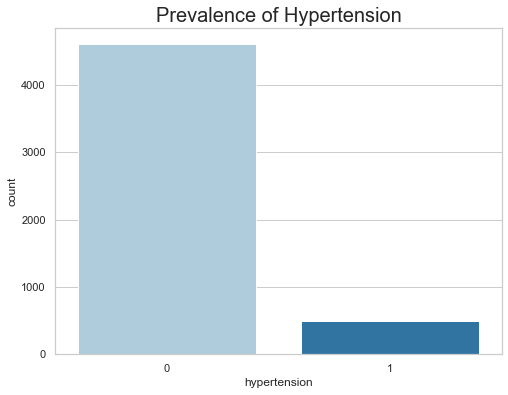

In [153]:
plt.figure(figsize=(8,6))
sns.countplot(x='hypertension', data=df, palette='Paired')
plt.title('Prevalence of Hypertension', size=20)

Text(0.5, 1.0, 'Prevalence of Heart Disease')

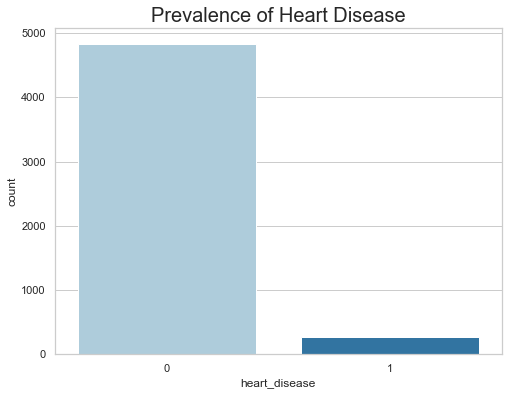

In [154]:
plt.figure(figsize=(8,6))
sns.countplot(x='heart_disease', data=df, palette='Paired')
plt.title('Prevalence of Heart Disease', size=20)

The previous 2 graphs further support the use of SMOTE analysis. 

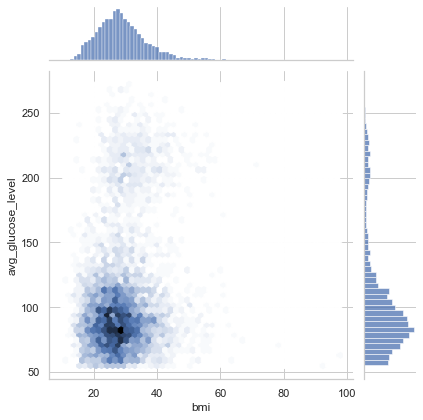

In [162]:
sns.jointplot(data=df, x='bmi', y='avg_glucose_level', kind="hex")

# Feature Engineering

#### Tasks:

1. Fix smoking category
2. Perform a train_test_split on the data
3. Create a categorical and numerical pipelines
4. Encode data
5. Merge and apply models

In [21]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

In [22]:
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [23]:
df[df.age<15].head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.00,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0


First, let's make it such that individuals under the age of 15 with an "Unknown" smoking status are labeled as "never smoked"

In [24]:
def smokeAdjuster(age, smoke):
    if (age<15):
        if (smoke=="Unknown"):
            return "never smoked"
        else: 
            return smoke
    else:
        return smoke

In [25]:
df['smoking_status'] = df.apply(lambda row: smokeAdjuster(row['age'],row['smoking_status']), axis=1)

In [26]:
df[df.age<15].head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,never smoked,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,never smoked,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,never smoked,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,never smoked,0
253,46136,Male,14.00,0,0,No,Never_worked,Rural,161.28,19.1,never smoked,0


In [11]:
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


# Data Preprocessing

### The remaining manipulations will be implemented via Pipelines/Column Transformers 

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X = df.drop(['id','stroke'], axis=1)

In [29]:
y = df['stroke']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3423 entries, 4540 to 860
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3423 non-null   object 
 1   age                3423 non-null   float64
 2   hypertension       3423 non-null   int64  
 3   heart_disease      3423 non-null   int64  
 4   ever_married       3423 non-null   object 
 5   work_type          3423 non-null   object 
 6   Residence_type     3423 non-null   object 
 7   avg_glucose_level  3423 non-null   float64
 8   bmi                3293 non-null   float64
 9   smoking_status     3423 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 294.2+ KB


In [32]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4540,Male,4.0,0,0,No,children,Urban,87.00,19.0,never smoked
3379,Female,41.0,0,0,Yes,Private,Urban,74.85,24.8,formerly smoked
479,Male,54.0,1,0,Yes,Private,Rural,198.69,NaN,smokes
3683,Male,80.0,0,1,Yes,Self-employed,Rural,95.49,31.6,Unknown
2997,Male,71.0,0,1,Yes,Private,Urban,204.98,NaN,formerly smoked


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [34]:
num_scale_feats = ['age', 'avg_glucose_level','bmi']
num_dummy = ['hypertension', 'heart_disease']
cat_feats = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [35]:
num_pip = Pipeline([
   ('imputer', SimpleImputer(strategy='median')),
   ('mms_scaler', MinMaxScaler()),
])

In [36]:
cat_pip = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [37]:
preprocessor = ColumnTransformer(
    [('numerical', num_pip, num_scale_feats),
     ('categorical', cat_pip, cat_feats)],
     remainder='passthrough')

In [ ]:
# preprocessor.fit(X_train)

In [ ]:
# cat_columns = preprocessor.named_transformers_['categorical']['encoder'].get_feature_names(cat_feats)
# columns = np.append(num_scale_feats, cat_columns)

In [136]:
# columns = np.append(columns, num_dummy)

In [138]:
# display(X_train)
# display(pd.DataFrame(preprocessor.transform(X_train), columns=columns))


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4540,Male,4.00,0,0,No,children,Urban,87.00,19.0,never smoked
3379,Female,41.00,0,0,Yes,Private,Urban,74.85,24.8,formerly smoked
479,Male,54.00,1,0,Yes,Private,Rural,198.69,NaN,smokes
3683,Male,80.00,0,1,Yes,Self-employed,Rural,95.49,31.6,Unknown
2997,Male,71.00,0,1,Yes,Private,Urban,204.98,NaN,formerly smoked
...,...,...,...,...,...,...,...,...,...,...
4427,Female,61.00,0,0,Yes,Private,Rural,144.14,29.8,never smoked
466,Female,61.00,1,0,Yes,Private,Rural,170.05,60.2,smokes
3092,Female,1.16,0,0,No,children,Urban,97.28,17.8,never smoked
3773,Female,38.00,0,0,Yes,Govt_job,Rural,93.93,21.5,never smoked


,age,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease
0,0.047852,0.147170,0.089224,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.499512,0.091081,0.156431,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.658203,0.662774,0.193511,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.975586,0.186363,0.235226,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.865723,0.691811,0.193511,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3418,0.743652,0.410950,0.214368,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3419,0.743652,0.530560,0.566628,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3420,0.013184,0.194627,0.075319,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3421,0.462891,0.179162,0.118192,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Perfect!

Cross referencing with the original table shows that everything was transformed correctly. 

For example, in the original, the 3rd and 5th feature vector is missing a value for 'bmi'. In the transformed dataframe, the 3rd and 5th feature vector has a value of 0.193511 for bmi, which is the imputed median of that feature. 


# Model Building

We'll bring down our ColumnTransformer from above and add a logistic regression model, now that we know it works.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [24]:
log_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('log_model', LogisticRegression())
])

In [25]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mms_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
          

In [26]:
log_preds = log_pipe.predict(X_test)

In [27]:
print(classification_report(y_test,log_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1590
           1       0.00      0.00      0.00        96

    accuracy                           0.94      1686
   macro avg       0.47      0.50      0.49      1686
weighted avg       0.89      0.94      0.92      1686



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ### That's not good. We'll definitely need to use some other models, and the case for SMOTE is only being amplified. 

In [28]:
svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svm_model', LinearSVC()),
])

In [29]:
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mms_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
          

In [30]:
svm_preds = svm_pipe.predict(X_test)

In [31]:
print(classification_report(y_test,log_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1590
           1       0.00      0.00      0.00        96

    accuracy                           0.94      1686
   macro avg       0.47      0.50      0.49      1686
weighted avg       0.89      0.94      0.92      1686



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
log_pipe.score(X_test, y_test)

0.9430604982206405

In [30]:
print('Training Score: {}'.format(log_pipe.score(X_train, y_train)))

print('Test Score: {}'.format(log_pipe.score(X_test, y_test)))

Training Score: 0.9553023663453112
Test Score: 0.9430604982206405


In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
from imblearn.pipeline import Pipeline as imbpipeline

In [45]:
logit_SMOTE_pipe = imbpipeline(steps=[['preprocessor', preprocessor],
    ['smote', SMOTE(random_state=12)],
    ['logit_model', LogisticRegression()]])

In [46]:
logit_SMOTE_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mms_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
          

In [47]:
logit_SMOTE_pred = logit_SMOTE_pipe.predict(X_test)

In [48]:
print(classification_report(y_test,logit_SMOTE_pred)

              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1590
           1       0.15      0.74      0.25        96

    accuracy                           0.74      1686
   macro avg       0.56      0.74      0.55      1686
weighted avg       0.93      0.74      0.81      1686



In [49]:
SVM_SMOTE_pipe = imbpipeline(steps=[['preprocessor', preprocessor],
    ['smote', SMOTE(random_state=12)],
    ['svm_model', LinearSVC()]])

In [50]:
SVM_SMOTE_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mms_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
          

In [52]:
SVM_SMOTE_pred = SVM_SMOTE_pipe.predict(X_test)

In [54]:
print(classification_report(y_test, SVM_SMOTE_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1590
           1       0.15      0.75      0.24        96

    accuracy                           0.73      1686
   macro avg       0.56      0.74      0.54      1686
weighted avg       0.93      0.73      0.80      1686



In [55]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
forest_SMOTE_pipe = imbpipeline(steps=[['preprocessor', preprocessor],
    ['smote', SMOTE(random_state=12)],
    ['forest_model', RandomForestClassifier(max_depth=2)]])

In [58]:
forest_SMOTE_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mms_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
          

In [59]:
forest_SMOTE_pipe.score(X_test, y_test)

0.6886120996441281

In [60]:
forest_SMOTE_pred = forest_SMOTE_pipe.predict(X_test)

In [62]:
print(classification_report(y_test, forest_SMOTE_pred))

              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1590
           1       0.14      0.83      0.23        96

    accuracy                           0.69      1686
   macro avg       0.56      0.76      0.52      1686
weighted avg       0.94      0.69      0.77      1686

